# Maintaining voltage setpoints via PandaModels.jl
### PandaModels.jl: Interfacing PowerModels with pandapower

This tutorial describes how to run the optimization for maintaining voltage setpoints via [PandaModels.jl](https://e2niee.github.io/PandaModels.jl/dev/).
Maintaining voltage setpoits (MVSP) is an optimization problem which is exclusively defined in [PandaModels.jl](https://e2niee.github.io/PandaModels.jl/dev/) and
needs the extra user defined parameters from pandapower.


The general mathematical model of MVSP is defined as follows:

\begin{align}
& \underset{\mathcal{X} = [q, ...]}{\text{minimize}}
& &  \sum_{i\in \mathcal{BI}} [v_i - setpoint\_v]^2 \\
& \text{subject to}
& & g(\mathcal{X})=0 \\
& & & h(\mathcal{X}) \leq 0
\end{align}

where $v_{i}$ is the voltage variable of bus $i$ in $\mathcal{BI}$ which denotes the set of buses located at the DSO-TSO interfaces. The $g(\mathcal{X})$ and $h(\mathcal{X})$, denote equality and inequality constraints, respectively. The $\mathcal{X}$ denotes the set of variables decisions, such as reactive power, $q$.

### Let's get started

So here is an example of how it works. First, we create cigre grid with pv and wind DERs(distribution energy resource) from pandapower's network database.

In [2]:
from pandapower.networks import create_cigre_network_mv
from pandapower.run import runpp
from pandapower.runpm import runpm_vstab
from pandapower.create import create_poly_cost
from copy import deepcopy

In [3]:
net = create_cigre_network_mv(with_der="pv_wind")

then we need to run powerflow to get the initial values:


In [4]:
net.sgen.p_mw = net.sgen.p_mw * 8
net.sgen.sn_mva = net.sgen.sn_mva * 8
runpp(net)

Let's have a look at the grid we created with pandapower plotting module:

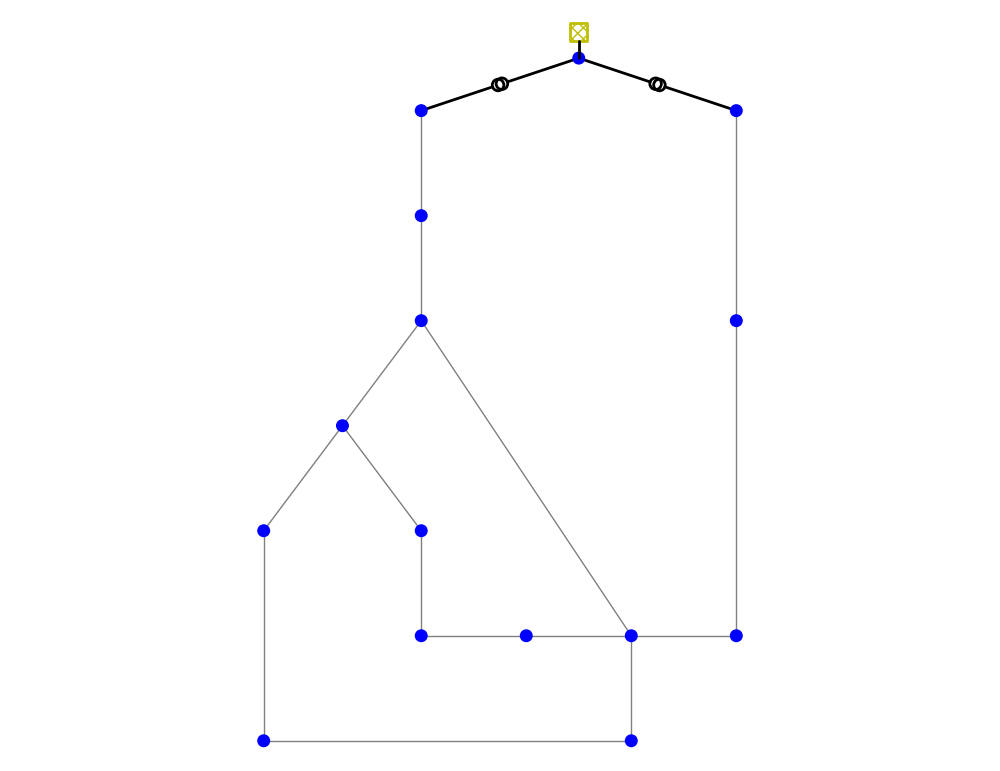

<Axes: >

In [5]:
import pandapower.plotting as plot
plot.set_line_geodata_from_bus_geodata(net)
plot.simple_plot(net)

let's keep a copy of the net for further comparision:

In [6]:
net_org = deepcopy(net)

Although VD is not a function of PowerModels and is exclusively modeled in Pandamodels, PandaModels similar to PowerModels follows the data structures from [InfrastructureModels.jl](https://github.com/lanl-ansi/InfrastructureModels.jl).
 In this data structure DERs are not defined separately unlike pandapower,
 then the uncontrollable load and sgens are converted to load and controllable elements are converted to the generator.

Accordingly, we need to set loads as uncontrollable elements and set DERs (sgens) as controllable elements.

In [7]:
net.load['controllable'] = False
net.sgen['controllable'] = True

now, lets set the optimization boundaries:

In [8]:
# lower and upper bounds for buses
net.bus["max_vm_pu"] = 1.1
net.bus["min_vm_pu"] = 0.9

# lower and upper bounds for external grid
net.ext_grid["max_q_mvar"] = 10000.0
net.ext_grid["min_q_mvar"] = -10000.0
net.ext_grid["max_p_mw"] = 10000.0
net.ext_grid["min_p_mw"] = -10000.0

in VD we need to keep the active power value for DER and generators constant to the calculated value from power flow.


In [9]:
# lower and upper bounds for DERs
net.sgen["max_p_mw"] = net.sgen.p_mw.values
net.sgen["min_p_mw"] = net.sgen.p_mw.values
net.sgen["max_q_mvar"] = net.sgen.p_mw.values * 0.328
net.sgen["min_q_mvar"] = -net.sgen.p_mw.values * 0.328

# lower and upper bounds for generators
net.gen["max_p_mw"] = net.gen.p_mw.values
net.gen["min_p_mw"] = net.gen.p_mw.values
net.gen["max_q_mvar"] = 10000.0
net.gen["min_q_mvar"] = -10000.0

Let's set a high upper bound for line and transformers to avoid congestion issue:

In [10]:
# lower and upper bounds for lines
net.trafo["max_loading_percent"] = 500.0
net.line["max_loading_percent"] = 500.0

I also we could set costs for sgens, gens and external grids in order to not get warnings during data correctness in julia side.

In [11]:
for idx in net.sgen.index:
    create_poly_cost(net, idx, "sgen", 1.0)
for idx in net.gen.index:
    create_poly_cost(net, idx, "gen", 1.0)
for idx in net.ext_grid.index:
    create_poly_cost(net, idx, "ext_grid", 1.0)

Finally, lets add our user defined parameter "setpoint_v". at first we need to add extra column called "pm_param/setpoint_v" in bus data,
then we set values for buses contain DERs(sgens):

In [12]:
net.bus["pm_param/setpoint_v"] = None
net.bus.loc[net.sgen.bus, "pm_param/setpoint_v"] = 0.99

Now lets run an MVSP through PandaModels and look at the results (Note that the first time the function is called, Julia is started in the background, which may take some time):

In [13]:
try:
    runpm_vstab(net)
except Exception as err:
    print(err)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
[info | PowerModels]: Suppressing information and warning messages for the rest of this session.  Use the Memento package for more fine-grained control of logging.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



Also, there more parameters and options that you can add as input while calling the Optimization Problem from PandaModles:

| parameter | description | type | default |
| :--- | :--- | :---: | :--- |
| correct_pm_network_data | checks if network data is correct. If not tries to correct it | bool | True |
| silence | Suppresses information and warning messages output by PowerModels | bool | True |
| pm_model | PowerModels.jl model to use | str | "ACPPowerModel" |
| pm_solver | "main" solver| str | "ipopt" |
| pm_mip_solver | mixed integer solver| str | "cbc" |
| pm_nl_solver | nonlinear solver| str | "ipopt" |
| pm_tol | default desired convergence tolerance for solver to use | float | 1e-8 |
| pm_log_level | solver log level in power models | int | 0 |
| delete_buffer_file | If True, the .json file used by PandaModels will be deleted after optimization. | bool | True |



lets check the result values for voltage and reactive power at buses contains DERs before and after VD:

In [14]:
# results from power flow
net_org.res_bus.vm_pu[net_org.sgen.bus]

3     1.039473
4     1.038293
5     1.037487
6     1.036603
8     1.053060
9     1.052446
10    1.051725
11    1.051589
7     1.075642
Name: vm_pu, dtype: float64

In [15]:
# results from VD
net.res_bus.vm_pu[net.sgen.bus]

3     0.984793
4     0.983774
5     0.983079
6     0.982361
8     0.992054
9     0.991521
10    0.990934
11    0.990804
7     1.006539
Name: vm_pu, dtype: float64

as exected the results are close to the defined setpoints, and as we set the active power constants we expect to get different results from power flow for reactive power:


In [16]:
# results from normal power flow
net_org.res_sgen.q_mvar

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
Name: q_mvar, dtype: float64

In [17]:
# results from MVSP
net.res_sgen.q_mvar

0    0.052467
1    0.052470
2    0.078711
3    0.078712
4    0.078694
5    0.078693
6    0.104932
7    0.026212
8   -3.135065
Name: q_mvar, dtype: float64